# **Project**: <font color='red'>*Hyperspectral Image (HSI) processing*</font><br><br>

# References
[TASK](https://github.com/geoav74/aueb_projects/blob/main/machine_learning/Project%20-%20Machine%20Learning%20and%20Computational%20Statistics.pdf)


In [ ]:
'''
There's no need to upgrage if you have the latest version of matplotlib. This
installation is needed so to have access to the matplotlib.pyplot.bar_labels feature
which i use later in my bar plot presentation. the .bar_labels feature shows
the values of each bar. Otherwise the relevant command can be omitted.
'''
!pip install matplotlib --upgrade

In [ ]:
# Mounting my google drive to the Colab's environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the file paths from my google drive directory
path_classification_labels_Salinas = '/content/drive/MyDrive/Colab Notebooks/classification_labels_Salinas.mat'
path_Salinas_cube = '/content/drive/MyDrive/Colab Notebooks/Salinas_cube.mat'
path_Salinas_endmembers = '/content/drive/MyDrive/Colab Notebooks/Salinas_endmembers.mat'
path_Salinas_gt = '/content/drive/MyDrive/Colab Notebooks/Salinas_gt'

[Text(0.5, 1.0, 'RGB Visualization of the 10th band of Salinas HSI')]

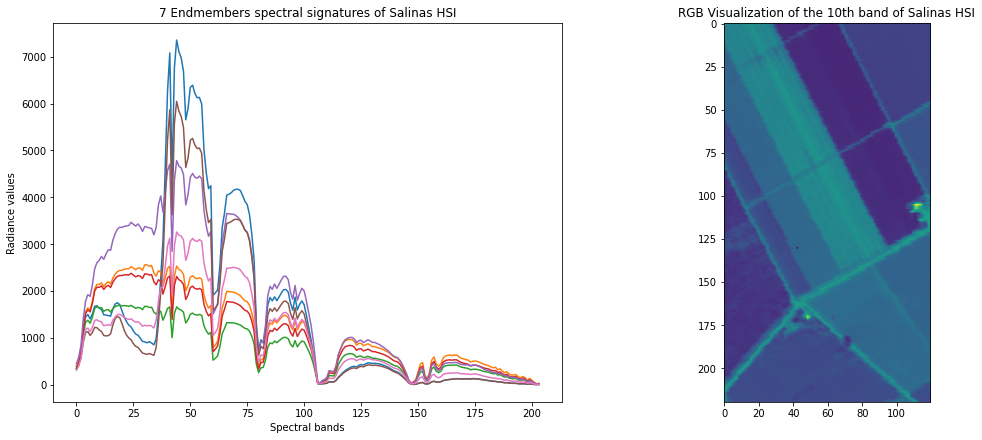

In [ ]:
import scipy.io as sio
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import time

# Importing the Salinas_cube file
Salinas = sio.loadmat(path_Salinas_cube)
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

# Importing the 204 spectral signatures for the 7 materials (endmembers)
ends = sio.loadmat(path_Salinas_endmembers) # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']

# Plotting the spectral
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6), constrained_layout=True)
ax1.plot(endmembers)
ax1.set(ylabel='Radiance values', xlabel='Spectral bands')
ax1.set(title='7 Endmembers spectral signatures of Salinas HSI')

# Importing the class labels for the 220x120 pixels
ground_truth= sio.loadmat(path_Salinas_gt)
labels=ground_truth['salinas_gt']

# Ploting a sample image wrt the 10th band over the 204
ax2.imshow(HSI[:,:,10])
ax2.set(title='RGB Visualization of the 10th band of Salinas HSI')

In [ ]:
# Collecting the pixels' indices of the labeling class which have non-zero value
x_index, y_index = np.nonzero(labels)

# Forming a new matrix containing the pixels from the HSI with the above indices for processing
HSI_new = HSI[x_index, y_index]

In [ ]:
# Printing out the dimensions of the data given
print(f'HSI dim:{HSI.shape}')
print(f'endmembers dim:{endmembers.shape}')
print(f'Label class dim:{labels.shape}')
print(f'Tranformed HSI non-zero values dim:{HSI_new.shape}')

HSI dim:(220, 120, 204)
endmembers dim:(204, 7)
Label class dim:(220, 120)
Tranformed HSI non-zero values dim:(16929, 204)


## **Part 1** (*Spectral Unmixing*)

### **A.** Estimating the abundance maps for the 7 materials applying different methods and computing the reconstruction error for each method, as follows:

##### **(a)** Performing the $\color{red}{\text{least squares}}$ method $[θ = (Χ^{Τ}Χ)^{-1}Χ^{T}y]$

In [ ]:
# This function assesses with the least square method returning the θ-values [abundance vector]
def leastSquares(y,X):
  # calculating the inverse matrix of X-Transpose by X
  invertedProduct = np.linalg.inv(np.dot(X.T, X))
  # calculating the product between the previous inverse matrix with the product between X-transpose with y
  ls =  invertedProduct.dot(X.T).dot(y.T)
  return ls

In [ ]:
# Computing the θ[theta]-values
start1 = time.time()
abundance_vector1 = leastSquares(HSI_new, endmembers)
end1 = time.time()
tt1 = (end1 - start1) * 10**3

# Printing out the theta-values dimension
print(f'Theta [abundane vector] dim: {abundance_vector1.shape}')
print(f'LS execution time: {tt1:.4f}ms')

Theta [abundane vector] dim: (7, 16929)
LS execution time: 23.0038ms


In [ ]:
# This function is plotting the abundance maps for each material
def abundance_maps(theta, x_i, y_i):

    fig, ax = plt.subplots(1, 7, figsize=(20, 6), constrained_layout = True)
    ax = ax.ravel()

    # constructing layers for each material and initialize them with zero-values
    layers = np.zeros((220, 120, 7))

    # plotting each layer
    for i in range(7):
      # assigning to specific pixels certain values
      layers[x_i, y_i, i] = theta[i, :]
      # depicting the material map
      ax[i].imshow(layers[:, :, i])
      ax[i].set_title(f'Material No: {i + 1}')

>(**i**) $\color{red}{\text{Abundace Maps}}$ for the **7** materials.

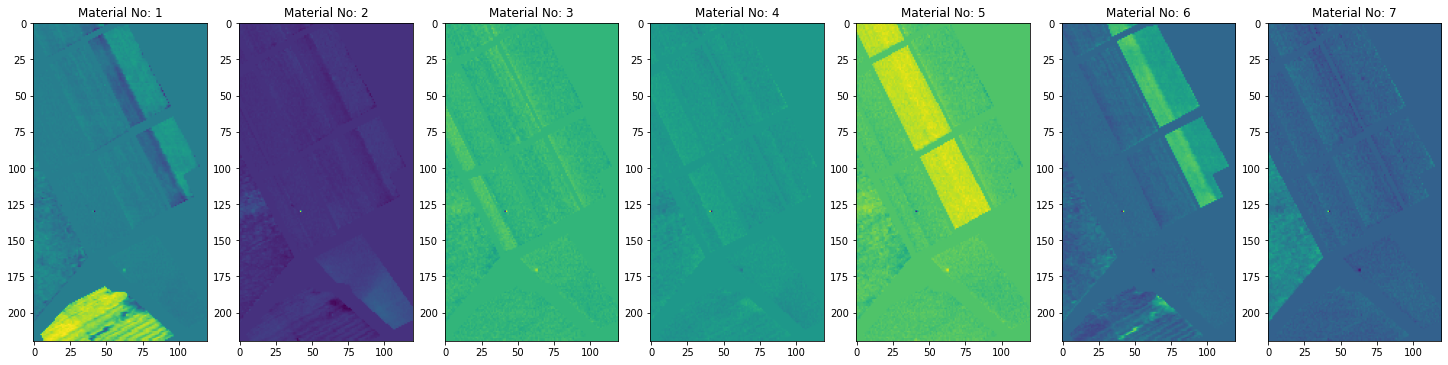

In [ ]:
# Plotting the abundance maps for each material
abundance_maps(abundance_vector1, x_index, y_index)

In [ ]:
# This function is calculating the reconstruction error
def reconstuctionError(label, y, X, theta):
  n = np.count_nonzero(label)
  reconstruction_error = np.linalg.norm(y.T - np.dot(X, theta)) ** 2 / n
  return reconstruction_error

>(**ii**) Computing the $\color{red}{\text{reconstruction error}}$ (we compute the quantity $ \frac{1}{N}\sum_{n=1}^{N} ∥y_{i} - Xθ_{i}∥^{2} $ for each **non-zero class label** pixels $y_{i}$ )

In [ ]:
# Calculating the reconstruction error
rE1 = reconstuctionError(labels, HSI_new, endmembers, abundance_vector1)

# Printing out the reconstruction error
print(f'Reconstruction Error (LS): {rE1:.3f}')

Reconstruction Error (LS): 35058.881


##### **(b)** Performing the $\color{red}{\text{least squares}}$ method imposing the $\color{red}{\text{sum-to-one}}$ constraint ($\sum θ = 1$)

In [ ]:
# library chosen to impose the sum-to-one constraint over the least squares method
from scipy.optimize import minimize

In [ ]:
# Defining the method to be used for estimating the θ-values [abundance vector]
def theta_sumToOne(HSI_new, endmembers, labels):

  # The least square function to be used for the optimization
  def ls_fun(x,a,b):
    ls = np.linalg.norm(a.dot(x) - b) ** 2
    return ls

  # defining the imposed number of minimization operations for the the non-zero label class pixels
  n = np.count_nonzero(labels)

  # defining the condition for θ-values
  cond = lambda theta: np.sum(theta) - 1

  # defining the constraint for minimization. The condition will be equal to zero
  constraint = {'type': 'eq', 'fun': cond}

  #initial 'guess' to zero for the minimization process
  init_val = np.zeros((1, 7))

  # Defining the minimization operation
  def min(t):
    for i in range(t):
      result = scipy.optimize.minimize(ls_fun, init_val,
                args=(endmembers, HSI_new[i, :]),
                method='SLSQP', tol='1e-6',
                constraints=constraint)

      yield result.x

  # aplying the optimization method for the non-zero label class pixels
  theta = np.array([*min(n)]).T

  return theta

In [ ]:
start2 = time.time()
abundance_vector2 = theta_sumToOne(HSI_new, endmembers, labels)
end2 = time.time()
tt2 = (end2 - start2) * 10**3

# Printing out the theta-values dimension
print(f'Theta [abundane vector] dim: {abundance_vector2.shape}')
print(f'LS (sum-to-one) execution time: {tt2:.4f}ms')

Theta [abundane vector] dim: (7, 16929)
LS (sum-to-one) execution time: 184118.1855ms


>(**i**) $\color{red}{\text{Abundace Maps}}$ for the **7** materials.

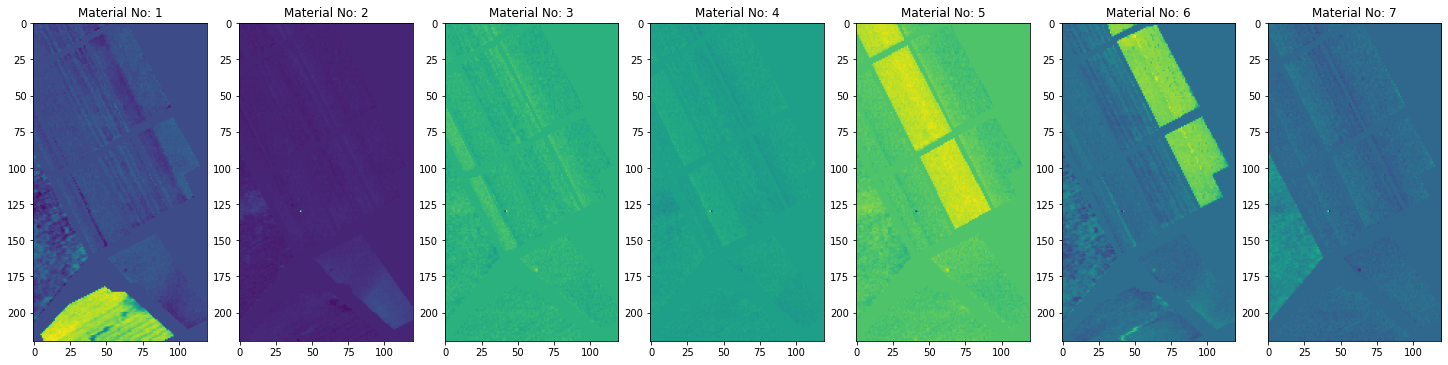

In [ ]:
# Plotting the abundance maps for each material
abundance_maps(abundance_vector2, x_index, y_index)

>(**ii**) Computing the $\color{red}{\text{reconstruction error}}$ (we compute the quantity $ \frac{1}{N}\sum_{n=1}^{N} ∥y_{i} - Xθ_{i}∥^{2} $ for each **non-zero class label** pixels $y_{i}$ )

In [ ]:
# Calculating the reconstruction error
rE2 = reconstuctionError(labels, HSI_new, endmembers, abundance_vector2)

# Printing out the reconstruction error
print(f'Reconstruction Error (LS sum-to-one): {rE2:.3f}')

Reconstruction Error (LS sum-to-one): 43082.576


##### **(c)** Performing the $\color{red}{\text{least squares}}$ method imposing the $\color{red}{\text{non-negativity}}$ constraint on the entries of $\color{red}{\text{θ}}$ (θ>0)

In [ ]:
# library chosen to impose the non-negativity constraint over the least squares method
from scipy.optimize import nnls

In [ ]:
# Defining the method to be used for estimating the θ-values [abundance vector]
def theta_nonNegative(HSI_new, endmembers, labels):

  # defining the imposed number of minimization operations for the the non-zero label class pixels
  n = np.count_nonzero(labels)

  # Defining the non-negative operation
  def nnThetaOp(t):
    for i in range(t):
      result, residuals = scipy.optimize.nnls(endmembers, HSI_new[i, :])
      yield result

  # aplying the optimization method for the non-zero label class pixels
  theta = np.array([*nnThetaOp(n)]).T

  return theta

In [ ]:
start3 = time.time()
abundance_vector3 = theta_nonNegative(HSI_new, endmembers, labels)
end3 = time.time()
tt3 = (end3 - start3) * 10**3

# Printing out the theta-values dimension
print(f'Theta [abundane vector] dim: {abundance_vector3.shape}')
print(f'LS non-negativity execution time: {tt3:.4f}ms')

Theta [abundane vector] dim: (7, 16929)
LS non-negativity execution time: 618.6349ms


>(**i**) $\color{red}{\text{Abundace Maps}}$ for the **7** materials.

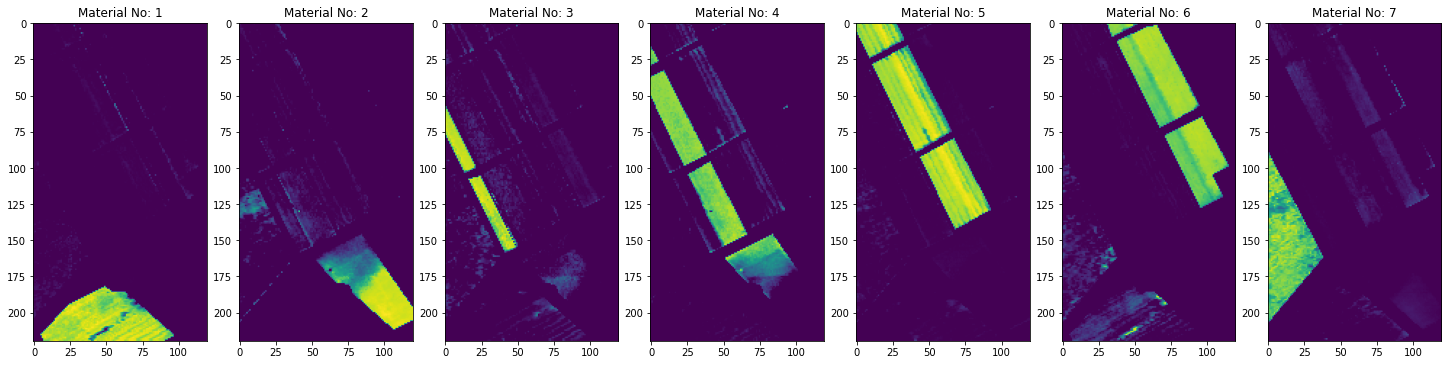

In [ ]:
# Plotting the abundance maps for each material
abundance_maps(abundance_vector3, x_index, y_index)

>(**ii**) Computing the $\color{red}{\text{reconstruction error}}$ (we compute the quantity $ \frac{1}{N}\sum_{n=1}^{N} ∥y_{i} - Xθ_{i}∥^{2} $ for each **non-zero class label** pixels $y_{i}$ )

In [ ]:
# Calculating the reconstruction error
rE3 = reconstuctionError(labels, HSI_new, endmembers, abundance_vector3)

# Printing out the reconstruction error
print(f'Reconstruction Error (LS non-negativity): {rE3:.3f}')

Reconstruction Error (LS non-negativity): 156104.182


##### **(d)** Performing the $\color{red}{\text{least squares}}$ method imposing the $\color{red}{\text{non-negativity}}$ and the $\color{red}{\text{sum-to-one}}$ constraint on the entries of $\color{red}{\text{θ}}$ ($\sum θ = 1$ and $\theta>0$)

In [ ]:
# For this part i'll use a modified version of the method introduced at Part1.(b)
def theta_sumToOne_nonNegative(HSI_new, endmembers, labels):

  # The least square function to be used for the optimization
  def ls_fun(x,a,b):
    ls = np.linalg.norm(a.dot(x) - b) ** 2
    return ls

  # defining the imposed number of minimization operations for the the non-zero label class pixels
  n = np.count_nonzero(labels)

  # defining the condition for θ-values
  cond = lambda theta: np.sum(theta) - 1

  # defining the constraint for minimization. The condition will be equal to zero
  constraint = {'type': 'eq', 'fun': cond}

  # defining θ-values boundaries for the 7 materials we're processing
  bnds = [(0, None)] * endmembers.shape[1]

  #initial 'guess' to zero for the minimization process
  init_val = np.zeros((1, 7))

  # Defining the minimization operation
  def min(t):
    for i in range(t):
      result = scipy.optimize.minimize(ls_fun, init_val,
                args=(endmembers, HSI_new[i, :]),
                method='SLSQP', tol='1e-6',
                bounds=bnds, constraints=constraint)

      yield result.x

  # aplying the optimization method for the non-zero label class pixels
  theta = np.array([*min(n)]).T

  return theta

In [ ]:
start4 = time.time()
abundance_vector4 = theta_sumToOne_nonNegative(HSI_new, endmembers, labels)
end4 = time.time()
tt4 = (end4 - start4) * 10**3

# Printing out the theta-values dimension
print(f'Theta [abundane vector] dim: {abundance_vector4.shape}')
print(f'LS (sum-to-one & non-negativity) execution time: {tt4:.4f}ms')

Theta [abundane vector] dim: (7, 16929)
LS (sum-to-one & non-negativity) execution time: 35559.4246ms


>(**i**) $\color{red}{\text{Abundace Maps}}$ for the **7** materials.

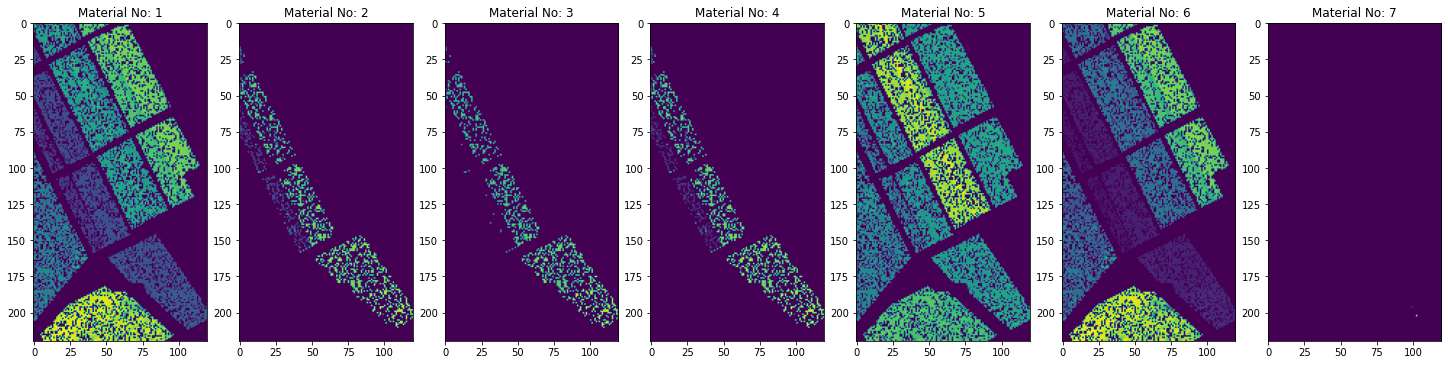

In [ ]:
# Plotting the abundance maps for each material
abundance_maps(abundance_vector4, x_index, y_index)

>(**ii**) Computing the $\color{red}{\text{reconstruction error}}$ (we compute the quantity $ \frac{1}{N}\sum_{n=1}^{N} ∥y_{i} - Xθ_{i}∥^{2} $ for each **non-zero class label** pixels $y_{i}$ )

In [ ]:
# Calculating the reconstruction error
rE4 = reconstuctionError(labels, HSI_new, endmembers, abundance_vector4)

# Printing out the reconstruction error
print(f'Reconstruction Error (LS sum-to-one & non-negativity): {rE4:.3f}')

Reconstruction Error (LS sum-to-one & non-negativity): 339047571.614


##### **(e)** Performing the $\color{red}{\text{LASSO}}$ method

In [ ]:
# Using the sklearn library for LASSO implementation
from sklearn import linear_model

In [ ]:
# Defining the method to be used for estimating the θ-values [abundance vector]
def thetaLasso(HSI_new, endmembers, labels):

  # defining the alpha parameter for lasso implementation
  clf = linear_model.Lasso(alpha=0.1)

  # defining the imposed number of lasso ops for the the non-zero label class pixels
  n = np.count_nonzero(labels)

  # Defining the lasso operation
  def lassoOp(c):

    for i in range(c):
      # fitting the model
      clf.fit(endmembers, HSI_new[i, :])
      # we need the coefficients
      yield clf.coef_

  # applying LASSO for the non-zero label class pixels
  theta = np.array([*lassoOp(n)]).T

  return theta

In [ ]:
start5 = time.time()
abundance_vector5 = thetaLasso(HSI_new, endmembers, labels)
end5 = time.time()
tt5 = (end5 - start5) * 10**3

# Printing out the theta-values dimension
print(f'Theta [abundane vector] dim: {abundance_vector5.shape}')
print(f'LASSO execution time: {tt5:.4f}ms')

>(**i**) $\color{red}{\text{Abundace Maps}}$ for the **7** materials.

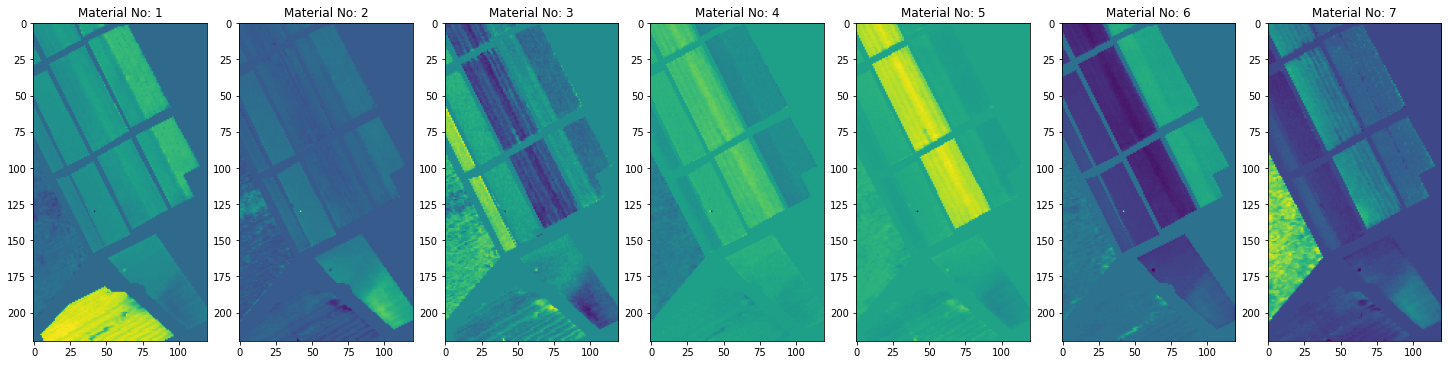

In [ ]:
# Plotting the abundance maps for each material
abundance_maps(abundance_vector5, x_index, y_index)

>(**ii**) Computing the $\color{red}{\text{reconstruction error}}$ (we compute the quantity $ \frac{1}{N}\sum_{n=1}^{N} ∥y_{i} - Xθ_{i}∥^{2} $ for each **non-zero class label** pixels $y_{i}$ )

In [ ]:
# Calculating the reconstruction error
rE5 = reconstuctionError(labels, HSI_new, endmembers, abundance_vector5)

# Printing out the reconstruction error
print(f'Reconstruction Error (LASSO): {rE5:.3f}')

Reconstruction Error (LASSO): 81922.301


### **B.** Comparing:
1. the results over the abundance maps produced for the 7 materials and
2. the reconstruction error for each selected method.

##### **B.1.** Comparing the abundance maps produced for the 7 materials

In [ ]:
def get_img(img):
  tmp = np.zeros((220,120))
  tmp[x_index, y_index] = img
  return tmp


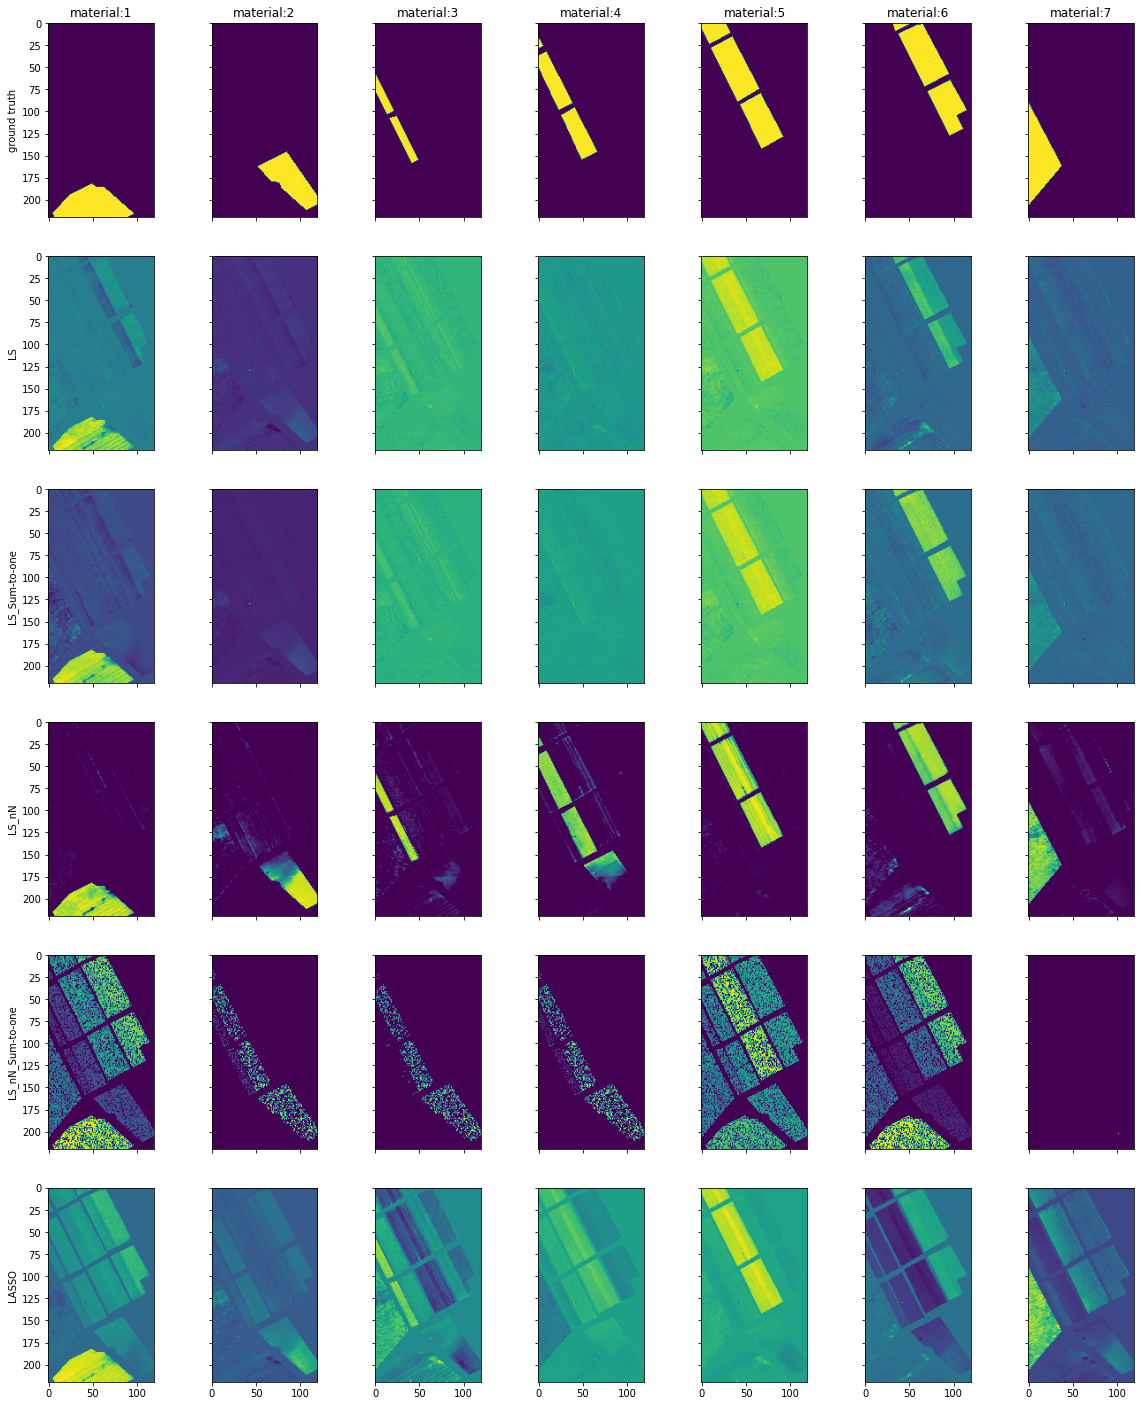

In [ ]:
import matplotlib.image as mpimg
# Visualizing our findings

# defining the methods to present
method = ['LS', 'LS_Sum-to-one', 'LS_nN', 'LS_nN_Sum-to-one', 'LASSO']
methods = ['ground truth'] + method

fig, axs = plt.subplots(6, 7, figsize=(20, 25), sharex='col', sharey='row')
for i in range(7):

  # ground-truth hides under labels. There's a disorder throughout the images,
  # so there's an adjustment in numbering
  axs[0,i].imshow(labels == (i+2 if i+2 != 8 else 1))
  axs[0,i].set_title(f'material:{i + 1}')
  if i < 6:
    axs[i, 0].set_ylabel(methods[i])
  # each method is presented
  axs[1, i].imshow(get_img(abundance_vector1[i, :]))
  axs[2, i].imshow(get_img(abundance_vector2[i, :]))
  axs[3, i].imshow(get_img(abundance_vector3[i, :]))
  axs[4, i].imshow(get_img(abundance_vector4[i, :]))
  axs[5, i].imshow(get_img(abundance_vector5[i, :]))


##### **B.2.** Comparing the reconstruction error

[Text(0, 3, '35058.9'),
 Text(0, 3, '43082.6'),
 Text(0, 3, '156104'),
 Text(0, 3, '3.39048e+08'),
 Text(0, 3, '81922.3')]

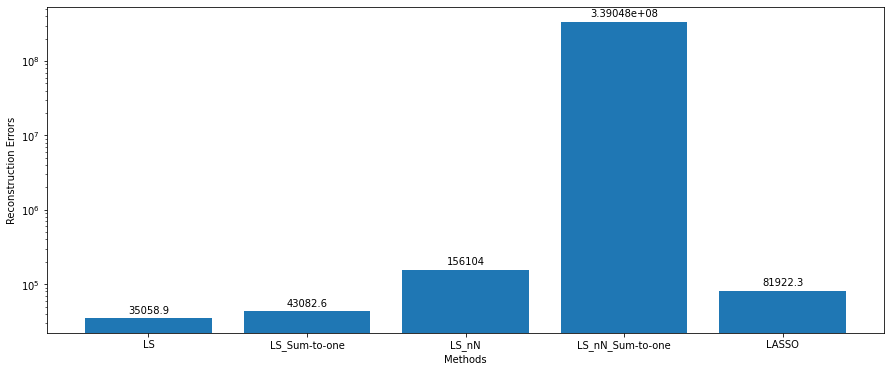

In [ ]:
# creating a bar diagram to depict our findings
rE = [rE1, rE2, rE3, rE4, rE5]
method = ['LS', 'LS_Sum-to-one', 'LS_nN', 'LS_nN_Sum-to-one', 'LASSO']
fig, ax = plt.subplots(figsize=(15,6))
tam = ax.bar(method, rE, log=True)
ax.set_ylabel('Reconstruction Errors')
ax.set_xlabel('Methods')

'''
this command can be omitted if we don't want to depict the values of
each bar or if we don't install the upgrade of matplotlib at the beginning
'''
ax.bar_label(tam, padding=3)

[Text(0, 3, '23.0038'),
 Text(0, 3, '184118'),
 Text(0, 3, '618.635'),
 Text(0, 3, '35559.4'),
 Text(0, 3, '36606')]

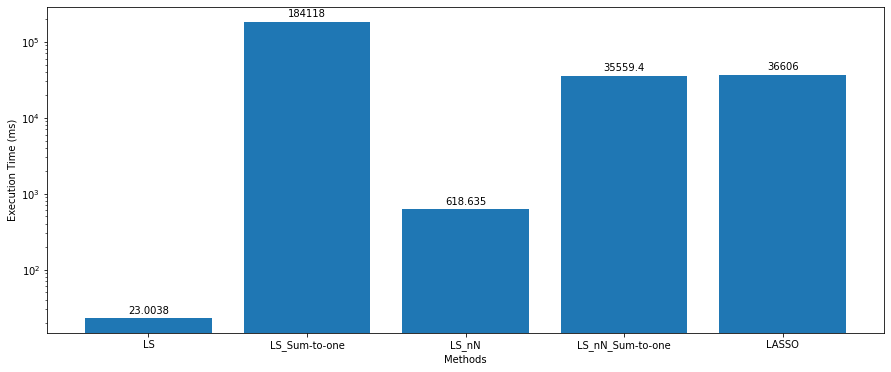

In [ ]:
# creating a bar diagram to depict our findings
t = [tt1, tt2, tt3, tt4, tt5]
method = ['LS', 'LS_Sum-to-one', 'LS_nN', 'LS_nN_Sum-to-one', 'LASSO']
fig, ax = plt.subplots(figsize=(15,6))
tam = ax.bar(method, t, log=True)
ax.set_ylabel('Execution Time (ms)')
ax.set_xlabel('Methods')

'''
this command can be omitted if we don't want to depict the values of
each bar or if we don't install the upgrade of matplotlib at the beginning
'''
ax.bar_label(tam, padding=3)

* Taking into account the reconstruction error bar chart, i can conclude that the uncostrained least squares method has the least amount of errors.
* Considering the abundance maps, all the methods did well with the non-negativity least square method having the closest approach to the ground truth.
* Considering the execution time, i can conclude that the unconstraint least squares method has the lowest which is reasonable since the other have to deal with some sort of constraint or calibration.
* Overall, we ca say that the least squares non-negativity method has on average better performance than the others.  

## **Part 2** (*Classification*)
### We still considering the pixels with non-zero class label. The task is to classify each one of these pixels to the appropriate given 7 classes. For that reason we'll use the following Classifiers:
* The $\color{red}{\text{Naive Bayes}}$ Classifier (1).
* The $\color{red}{\text{Minimum Euclidean Distance}}$ Classifier (2).
* The $\color{red}{\text{K-NN}}$ Classifier (3).
* The $\color{red}{\text{Bayesian}}$ Classifier (4).


### **A.** For each classifier:
> **(i)** Train the classifier performing 10-fold cross validation (training process x10 times). Report the estimated validation error as the mean of the 10 resulting error values). Computing and report the associated standard deviation.

> **(ii)** Evaluate the classifiers performance by:
* Computing the confusion matrix and identify the misclassified classes.
* Compute the success rate of the classifier (sum of diagonal elements of the confusion matrix divided by the sum of all elements of the matrix).

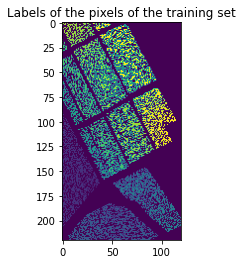

In [ ]:
# Trainining set for classification
Salinas_labels = sio.loadmat(path_classification_labels_Salinas)
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [ ]:
print(f'Training set dim: {Training_Set.shape}')
print(f'Test set dim: {Test_Set.shape}')
print(f'Operational set dim: {Operational_Set.shape}')

Training set dim: (220, 120)
Test set dim: (220, 120)
Operational set dim: (220, 120)


In [ ]:
# both train and test datasets includes non-zero pixel values
X_train = HSI[Training_Set != 0]
y_train = Training_Set[Training_Set != 0]

X_test = HSI[Test_Set != 0]
y_test = Test_Set[Test_Set != 0]

print(f'X training set dim: {X_train.shape}')
print(f'y training set dim: {y_train.shape}\n\n')
print(f'X test set dim: {X_test.shape}')
print(f'y test set dim: {y_test.shape}')

X training set dim: (8465, 204)
y training set dim: (8465,)


X test set dim: (4232, 204)
y test set dim: (4232,)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

##### **A.(1)** $\color{red}{\text{Naive Bayes}}$ Classifier

In [ ]:
# Selecting the Gaussian Naive Bayes
gnb_classifier = GaussianNB()

In [ ]:
# fiting the train dataset using the classifier
gnb_classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
# making predictions using the testing dataset
nb_y_pred = gnb_classifier.predict(X_test)

In [ ]:
'''
Computing the 10-fold cross validation for the classifier.
For the scoring it's used the 'accuracy' method which estimates the success rate
'''
nb_cvs = cross_val_score(gnb_classifier, X=X_train, y=y_train, cv=10, scoring='accuracy')

In [ ]:
'''
printing out the requested information about the mean error and standard deviation after
training and performing a 10-fold cross validation.
Since the cross validation scrore computes over the successes substracting it from 1
will give us the estimated error.
'''
nb_mean = 1 - np.mean(nb_cvs)
nb_std = np.std(nb_cvs)
print(f'The estimated mean error for Naive Bayes classifier: {nb_mean:.3f}')
print(f'The estimated standard deviation for Naive Bayes classifier: {nb_std:.3f}')

The estimated mean error for Naive Bayes classifier: 0.026
The estimated standard deviation for Naive Bayes classifier: 0.016


In [ ]:
# creating the confusion matrix
nb_confMatrix = confusion_matrix(nb_y_pred, y_test)

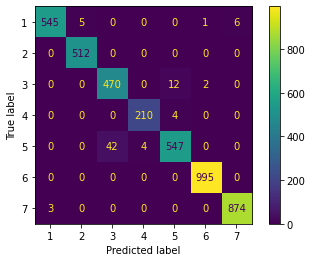

In [ ]:
#displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=nb_confMatrix, display_labels=gnb_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
# printing out the success rate for the classifier
nb_success = np.trace(nb_confMatrix) / np.sum(nb_confMatrix)
print(f'The success rate for Naive Bayes classifier: {nb_success:.3f}')

The success rate for Naive Bayes classifier: 0.981


##### **A.(2)** $\color{red}{\text{Minimum Euclidean Distance}}$ Classifier

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

In [ ]:
# Creating the Euclidean classifier from scratch
class MinEuclideanClf(BaseEstimator, ClassifierMixin):

  '''
  Creating the fitting method, as follows:
  - check if X & y have the correct shape.
  - store the found classes.
  - estimating the mean of the features for future use of the model
  '''
  def fit(self, X, y):
    X, y = check_X_y(X, y)
    self.classes_ = unique_labels(y)
    self.numOfClasses = len(np.unique(y))
    self.X_ = X
    self.y_ = y
    k, m = self.X_.shape
    self.mean_ = np.zeros((self.numOfClasses, m))

    for i in range(self.numOfClasses):
      self.mean_[i] = np.mean(self.X_[self.y_ == i + 1], axis=0)

    return self

  '''
  The Euclidean distance between 2 arrays to be used for our calculations
  '''
  @staticmethod
  def euclDst(A, B):
    tmp = A - B
    eucl_dst = np.dot(tmp, tmp)
    return eucl_dst

  '''
  Creating the predicting method, as follows:
  - check if fit() has already applied.
  - validating the testing sample.
  - minimizing the Euclidean distances.
  - return prediction class for the pixels.
  '''
  def predict(self, X):
    check_is_fitted(self, ['X_', 'y_'])
    X = check_array(X)
    k, m = X.shape
    pred_y = np.zeros(k)

    for i in range(k):
      dst = np.zeros(self.numOfClasses)
      for j in range(self.numOfClasses):
        dst[j] = self.euclDst(X[i], self.mean_[j])
      pred_y[i] = np.argmin(dst)  + 1

    return pred_y

In [ ]:
# Selecting the classifier we just created
minEucl_clf = MinEuclideanClf()

In [ ]:
# fiting the train dataset using the classifier
minEucl_clf.fit(X_train, y_train)

MinEuclideanClf()

In [ ]:
# making predictions using the testing dataset
minEuclClf_y_pred = minEucl_clf.predict(X_test)

In [ ]:
'''
Computing the 10-fold cross validation for the classifier.
For the scoring it's used the 'accuracy' method which estimates the success rate
'''
minEuclClf_cvs = cross_val_score(minEucl_clf, X=X_train, y=y_train, cv=10, scoring='accuracy')

In [ ]:
'''
printing out the requested information about the mean error and standard deviation after
training and performing a 10-fold cross validation.
Since the cross validation scrore computes over the successes substracting it from 1
will give us the estimated error.
'''
minEuclClf_mean = 1 - np.mean(minEuclClf_cvs)
minEuclClf_std = np.std(minEuclClf_cvs)
print(f'The estimated mean error for Minimum Euclidean classifier: {minEuclClf_mean:.3f}')
print(f'The estimated standard deviation for Minimum Euclidean classifier: {minEuclClf_std:.3f}')

The estimated mean error for Minimum Euclidean classifier: 0.049
The estimated standard deviation for Minimum Euclidean classifier: 0.021


In [ ]:
# creating the confusion matrix
minEuclClf_confMatrix = confusion_matrix(minEuclClf_y_pred, y_test)

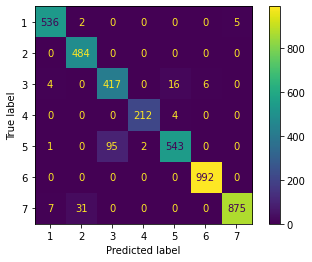

In [ ]:
#displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=minEuclClf_confMatrix, display_labels=minEucl_clf.classes_)
disp.plot()
plt.show()

In [ ]:
# printing out the success rate for the classifier
minEuclClf_success = np.trace(minEuclClf_confMatrix) / np.sum(minEuclClf_confMatrix)
print(f'The success rate for Naive Bayes classifier: {minEuclClf_success:.3f}')

The success rate for Naive Bayes classifier: 0.959


##### **A.(3)** $\color{red}{\text{K-NN}}$ Classifier

In [ ]:
# Selecting the K-NN classifier
knn = KNeighborsClassifier()

In [ ]:
# fiting the train dataset using the classifier
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# making predictions using the testing dataset
knn_y_pred = knn.predict(X_test)

In [ ]:
'''
Computing the 10-fold cross validation for the classifier.
For the scoring it's used the 'accuracy' method which estimates the success rate
'''
knn_cvs = cross_val_score(knn, X=X_train, y=y_train, cv=10, scoring='accuracy')

In [ ]:
'''
printing out the requested information about the mean error and standard deviation after
training and performing a 10-fold cross validation.
Since the cross validation scrore computes over the successes substracting it from 1
will give us the estimated error.
'''
knn_mean = 1 - np.mean(knn_cvs)
knn_std = np.std(knn_cvs)
print(f'The estimated mean error for K-NN classifier: {knn_mean:.3f}')
print(f'The estimated standard deviation for K-NN classifier: {knn_std:.3f}')

The estimated mean error for K-NN classifier: 0.010
The estimated standard deviation for K-NN classifier: 0.015


In [ ]:
# creating the confusion matrix
knn_confMatrix = confusion_matrix(knn_y_pred, y_test)

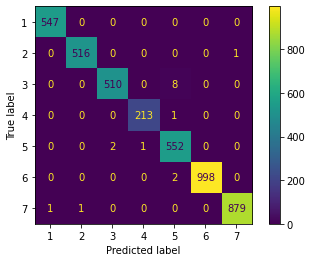

In [ ]:
#displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confMatrix, display_labels=knn.classes_)
disp.plot()
plt.show()

In [ ]:
# printing out the success rate for the classifier
knn_success = np.trace(knn_confMatrix) / np.sum(knn_confMatrix)
print(f'The success rate for K-NN classifier: {knn_success:.3f}')

The success rate for K-NN classifier: 0.996


##### **A.(4)** $\color{red}{\text{Bayesian}}$ Classifier

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
'''
These classifiers are representing the Bayes classifier. LDA is a special case
of QDA, where the Gaussians for each class are assumed to share the same
covariance matrix
'''
bayes_clf1 = LinearDiscriminantAnalysis()
bayes_clf2 = QuadraticDiscriminantAnalysis()

In [ ]:
# fiting the train dataset using the classifier
bayes_clf1.fit(X_train, y_train)
bayes_clf2.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [ ]:
# making predictions using the testing dataset
bayes_clf1_y_pred = bayes_clf1.predict(X_test)
bayes_clf2_y_pred = bayes_clf2.predict(X_test)

In [ ]:
'''
Computing the 10-fold cross validation for the classifier.
For the scoring it's used the 'accuracy' method which estimates the success rate
'''
bayes_clf1_cvs = cross_val_score(bayes_clf1, X=X_train, y=y_train, cv=10, scoring='accuracy')
bayes_clf2_cvs = cross_val_score(bayes_clf2, X=X_train, y=y_train, cv=10, scoring='accuracy')

In [ ]:
'''
printing out the requested information about the mean error and standard deviation after
training and performing a 10-fold cross validation.
Since the cross validation scrore computes over the successes substracting it from 1
will give us the estimated error.
'''
b_mean = 1 - np.mean(bayes_clf1_cvs)
b_std = np.std(bayes_clf1_cvs)
print(f'The estimated mean error for linear Bayes classifier: {b_mean:.3f}')
print(f'The estimated standard deviation for linear Bayes classifier: {b_std:.3f}')

The estimated mean error for linear Bayes classifier: 0.005
The estimated standard deviation for linear Bayes classifier: 0.006


In [ ]:
'''
printing out the requested information about the mean error and standard deviation after
training and performing a 10-fold cross validation.
Since the cross validation scrore computes over the successes substracting it from 1
will give us the estimated error.
'''
print(f'The estimated mean error for quadratic Bayes classifier: {(1 - np.mean(bayes_clf2_cvs)):.3f}')
print(f'The estimated standard deviation for quadratic Bayes classifier: {(np.std(bayes_clf2_cvs)):.3f}')

The estimated mean error for quadratic Bayes classifier: 0.034
The estimated standard deviation for quadratic Bayes classifier: 0.006


In [ ]:
# creating the confusion matrix
bayes_clf1_confMatrix = confusion_matrix(bayes_clf1_y_pred, y_test)
bayes_clf2_confMatrix = confusion_matrix(bayes_clf2_y_pred, y_test)

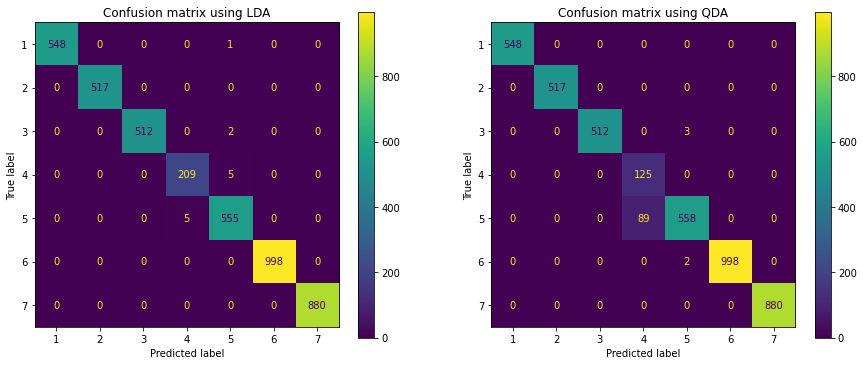

In [ ]:
#displaying the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=bayes_clf1_confMatrix, display_labels=bayes_clf1.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=bayes_clf2_confMatrix, display_labels=bayes_clf2.classes_)
disp1.plot(ax=ax1)
disp2.plot(ax=ax2)
ax1.set(title='Confusion matrix using LDA')
ax2.set(title='Confusion matrix using QDA')
plt.show()

In [ ]:
# printing out the success rate for the classifier
bayes_success1 = np.trace(bayes_clf1_confMatrix) / np.sum(bayes_clf1_confMatrix)
bayes_success2 = np.trace(bayes_clf2_confMatrix) / np.sum(bayes_clf2_confMatrix)
print(f'The success rate for Bayes classifier: {bayes_success1:.3f}')
print(f'The success rate for Bayes classifier: {bayes_success2:.3f}')

The success rate for Bayes classifier: 0.997
The success rate for Bayes classifier: 0.978


Since the linear 'version' (LDA) of Bayes implementation has better scores overall, i'll use this for the comparison with the other classifiers.

### **B.** Comparing the results btween classifiers.

[Text(0, 3, '0.0160232'),
 Text(0, 3, '0.020859'),
 Text(0, 3, '0.0145364'),
 Text(0, 3, '0.00591047')]

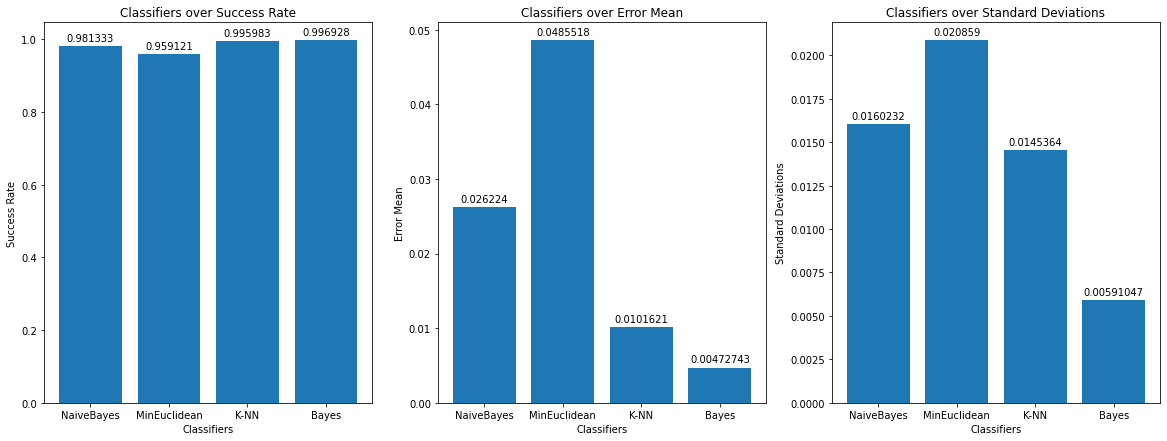

In [ ]:
success_rate = [nb_success, minEuclClf_success, knn_success, bayes_success1]
error_mean = [nb_mean, minEuclClf_mean, knn_mean, b_mean]
stds = [nb_std, minEuclClf_std, knn_std, b_std]
classifier = ['NaiveBayes', 'MinEuclidean', 'K-NN', 'Bayes']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))
p1 = ax1.bar(classifier, success_rate)
ax1.set_ylabel('Success Rate')
ax1.set_xlabel('Classifiers')
ax1.set_title('Classifiers over Success Rate')

'''
this command can be omitted if we don't want to depict the values of
each bar or if we don't install the upgrade of matplotlib at the beginning
'''
ax1.bar_label(p1, padding=3)

p2 = ax2.bar(classifier, error_mean)
ax2.set_ylabel('Error Mean')
ax2.set_xlabel('Classifiers')
ax2.set_title('Classifiers over Error Mean')
ax2.bar_label(p2, padding=3)

p3 = ax3.bar(classifier, stds)
ax3.set_ylabel('Standard Deviations')
ax3.set_xlabel('Classifiers')
ax3.set_title('Classifiers over Standard Deviations')
ax3.bar_label(p3, padding=3)

* Considering the confusion matrices, i can conclude that all classifiers met our needs with high scores.
* Over the error mean, the Euclidean classifier has the largest mean error.
* Over the standard deviation, the Euclidean classifier has the largest one.
* Overall, on average, Bayes classifier has better perfomance than the others.

## **Part 3** (*Combination*)

Common observations using spectral unmixing and several classifiers to process the HSI could be:
* A slight problem idenfying fallow areas.
* Both give us good scores overall.